In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_Cinic10(nn.Module):
    def __init__(self):
        super(CNN_Cinic10, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 2048, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(2048, 512)
        self.z_log_var = nn.Linear(2048, 512)

        self.decoder = nn.Sequential(
            nn.Linear(512, 2048),
            nn.Unflatten(1, (2048, 1, 1)),
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

    def get_latent(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)

        return lat

In [3]:
mean = [0.47889522, 0.47227842, 0.43047404]
std = [0.24205776, 0.23828046, 0.25874835]

transform = transforms.Compose(
    [
        # transforms.RandomAffine(degrees=(-1, 1), translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]
)

root_dir = '/media/mountHDD2/data/cinic10'

trainset = ImageFolder(root=root_dir + "/train", transform=transform)
train_dl = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=24)
validset = ImageFolder(root=root_dir + "/valid", transform=transform)
valid_dl = DataLoader(validset, batch_size=128, shuffle=False, num_workers=24)
testset = ImageFolder(root=root_dir + "/test", transform=transform)
test_dl = DataLoader(testset, batch_size=128, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

90000 90000 90000
704 704 704


In [4]:
sample, _ = trainset[0]
print(sample.shape)

torch.Size([3, 32, 32])


In [5]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 1)

model = CNN_Cinic10().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 200

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(valid_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 52.83it/s]


Epoch: 0 - TrainRecLoss: 2061.434034174139 - ValidRecLoss: 1557.613788431341
Epoch: 0 - TrainDivLoss: 195.48481868071988 - ValidDivLoss: 55.158764411102645


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.61it/s]


Epoch: 1 - TrainRecLoss: 1475.0899122411554 - ValidRecLoss: 1377.36639993841
Epoch: 1 - TrainDivLoss: 50.33737447045066 - ValidDivLoss: 50.55007754672658


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.77it/s]


Epoch: 2 - TrainRecLoss: 1288.532390941273 - ValidRecLoss: 1227.4217708761041
Epoch: 2 - TrainDivLoss: 47.12710773402994 - ValidDivLoss: 48.43746795437553


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.99it/s]


Epoch: 3 - TrainRecLoss: 1196.5301827517424 - ValidRecLoss: 1173.485915184021
Epoch: 3 - TrainDivLoss: 46.456260171803564 - ValidDivLoss: 47.16737039522691


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.73it/s]


Epoch: 4 - TrainRecLoss: 1147.7214261835272 - ValidRecLoss: 1116.0864587263627
Epoch: 4 - TrainDivLoss: 46.76098694042726 - ValidDivLoss: 48.33576434308832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.92it/s]


Epoch: 5 - TrainRecLoss: 1092.2243157300081 - ValidRecLoss: 1073.2902253757823
Epoch: 5 - TrainDivLoss: 52.253333015875384 - ValidDivLoss: 51.186533044685014


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.81it/s]


Epoch: 6 - TrainRecLoss: 1062.105037169023 - ValidRecLoss: 1043.7147675427523
Epoch: 6 - TrainDivLoss: 52.85806249488484 - ValidDivLoss: 55.182562947273254


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.78it/s]


Epoch: 7 - TrainRecLoss: 1035.341475833546 - ValidRecLoss: 1007.6349351189353
Epoch: 7 - TrainDivLoss: 53.52463849024339 - ValidDivLoss: 51.96008289402182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.94it/s]


Epoch: 8 - TrainRecLoss: 1014.135740626942 - ValidRecLoss: 991.096087845889
Epoch: 8 - TrainDivLoss: 53.143296192992814 - ValidDivLoss: 54.70720247788863


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.74it/s]


Epoch: 9 - TrainRecLoss: 993.0294329903343 - ValidRecLoss: 982.9712469794533
Epoch: 9 - TrainDivLoss: 55.4771092263135 - ValidDivLoss: 56.2080267180096


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.75it/s]


Epoch: 10 - TrainRecLoss: 978.9465890364213 - ValidRecLoss: 963.6885577115146
Epoch: 10 - TrainDivLoss: 57.071460127830505 - ValidDivLoss: 58.51511969349601


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.85it/s]


Epoch: 11 - TrainRecLoss: 963.8021394556218 - ValidRecLoss: 949.0893184921958
Epoch: 11 - TrainDivLoss: 59.002293863079764 - ValidDivLoss: 59.22582957419482


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.63it/s]


Epoch: 12 - TrainRecLoss: 953.2343466498635 - ValidRecLoss: 1000.6676387786865
Epoch: 12 - TrainDivLoss: 59.70366977561604 - ValidDivLoss: 60.17415521361611


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.86it/s]


Epoch: 13 - TrainRecLoss: 950.118313962763 - ValidRecLoss: 952.5190267562866
Epoch: 13 - TrainDivLoss: 59.25534095547416 - ValidDivLoss: 58.85851142081347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.48it/s]


Epoch: 14 - TrainRecLoss: 938.5647940202193 - ValidRecLoss: 921.802688815377
Epoch: 14 - TrainDivLoss: 59.6805382696065 - ValidDivLoss: 60.9196758703752


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.91it/s]


Epoch: 15 - TrainRecLoss: 925.6424900401722 - ValidRecLoss: 913.082691972906
Epoch: 15 - TrainDivLoss: 60.46560229496522 - ValidDivLoss: 59.8670766136863


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.33it/s]


Epoch: 16 - TrainRecLoss: 919.8379509665749 - ValidRecLoss: 912.4173067699779
Epoch: 16 - TrainDivLoss: 60.81823253631592 - ValidDivLoss: 62.81722315874967


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.68it/s]


Epoch: 17 - TrainRecLoss: 912.8272653059526 - ValidRecLoss: 899.717349876057
Epoch: 17 - TrainDivLoss: 61.73159233006564 - ValidDivLoss: 61.72629851102829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 52.77it/s]


Epoch: 18 - TrainRecLoss: 907.6556868119674 - ValidRecLoss: 897.4527670686895
Epoch: 18 - TrainDivLoss: 62.106858085502274 - ValidDivLoss: 62.33014506643469


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.95it/s]


Epoch: 19 - TrainRecLoss: 901.106011390686 - ValidRecLoss: 896.527408209714
Epoch: 19 - TrainDivLoss: 63.1574038808996 - ValidDivLoss: 64.27972601760517


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.33it/s]


Epoch: 20 - TrainRecLoss: 896.4171549190174 - ValidRecLoss: 887.6735673817722
Epoch: 20 - TrainDivLoss: 63.74212002212351 - ValidDivLoss: 64.23290853066878


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.87it/s]


Epoch: 21 - TrainRecLoss: 890.2185701890426 - ValidRecLoss: 883.3962249755859
Epoch: 21 - TrainDivLoss: 64.4808353564956 - ValidDivLoss: 63.98578157208183


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.61it/s]


Epoch: 22 - TrainRecLoss: 886.3368289253929 - ValidRecLoss: 875.1392353231257
Epoch: 22 - TrainDivLoss: 64.63769908926703 - ValidDivLoss: 64.79621828686108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.98it/s]


Epoch: 23 - TrainRecLoss: 882.9537627480247 - ValidRecLoss: 874.3093243945729
Epoch: 23 - TrainDivLoss: 64.86618105931716 - ValidDivLoss: 64.97869310053912


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.19it/s]


Epoch: 24 - TrainRecLoss: 877.5446949872104 - ValidRecLoss: 872.1271841742775
Epoch: 24 - TrainDivLoss: 65.73834816434167 - ValidDivLoss: 65.70556750622663


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.67it/s]


Epoch: 25 - TrainRecLoss: 873.6604296944358 - ValidRecLoss: 870.0469003590671
Epoch: 25 - TrainDivLoss: 65.95137067274614 - ValidDivLoss: 66.97219014167786


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.46it/s]


Epoch: 26 - TrainRecLoss: 871.2891728661277 - ValidRecLoss: 867.3379306793213
Epoch: 26 - TrainDivLoss: 66.1160947192799 - ValidDivLoss: 66.01575950059024


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.00it/s]


Epoch: 27 - TrainRecLoss: 867.0089409568093 - ValidRecLoss: 867.4721466844732
Epoch: 27 - TrainDivLoss: 66.22233573956923 - ValidDivLoss: 66.1633641503074


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.62it/s]


Epoch: 28 - TrainRecLoss: 865.4970004341819 - ValidRecLoss: 863.5447125001388
Epoch: 28 - TrainDivLoss: 66.23307441581379 - ValidDivLoss: 65.80957253954627


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.78it/s]


Epoch: 29 - TrainRecLoss: 862.9676882136952 - ValidRecLoss: 868.0968421589245
Epoch: 29 - TrainDivLoss: 66.18309343944897 - ValidDivLoss: 65.80590089884672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.74it/s]


Epoch: 30 - TrainRecLoss: 860.5568759224632 - ValidRecLoss: 859.7329537218267
Epoch: 30 - TrainDivLoss: 66.22554752501574 - ValidDivLoss: 66.59063458442688


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.18it/s]


Epoch: 31 - TrainRecLoss: 856.8565782200207 - ValidRecLoss: 858.7470044656234
Epoch: 31 - TrainDivLoss: 66.18675567887045 - ValidDivLoss: 66.3427476070144


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.18it/s]


Epoch: 32 - TrainRecLoss: 853.1065677296032 - ValidRecLoss: 858.1155549829656
Epoch: 32 - TrainDivLoss: 66.84405597773466 - ValidDivLoss: 67.45010373809122


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.77it/s]


Epoch: 33 - TrainRecLoss: 850.0093265880238 - ValidRecLoss: 855.2549254244024
Epoch: 33 - TrainDivLoss: 67.21231190724806 - ValidDivLoss: 66.38489566066049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.62it/s]


Epoch: 34 - TrainRecLoss: 847.7980066646229 - ValidRecLoss: 854.1975630413402
Epoch: 34 - TrainDivLoss: 67.33493489568883 - ValidDivLoss: 67.64096327803351


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.60it/s]


Epoch: 35 - TrainRecLoss: 845.6787856708874 - ValidRecLoss: 850.9301343831149
Epoch: 35 - TrainDivLoss: 67.4436163035306 - ValidDivLoss: 67.11037674275312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.86it/s]


Epoch: 36 - TrainRecLoss: 844.4117697802457 - ValidRecLoss: 853.3223292177373
Epoch: 36 - TrainDivLoss: 67.62286615371704 - ValidDivLoss: 67.69613468105143


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.91it/s]


Epoch: 37 - TrainRecLoss: 840.5798610340465 - ValidRecLoss: 848.8420894796199
Epoch: 37 - TrainDivLoss: 68.27138944105668 - ValidDivLoss: 68.39971166307276


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.25it/s]


Epoch: 38 - TrainRecLoss: 838.4782250144265 - ValidRecLoss: 847.6002419645137
Epoch: 38 - TrainDivLoss: 68.61088520830327 - ValidDivLoss: 68.61543146588586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.96it/s]


Epoch: 39 - TrainRecLoss: 835.3144647424871 - ValidRecLoss: 845.6489712541753
Epoch: 39 - TrainDivLoss: 68.64940648729151 - ValidDivLoss: 68.5098006454381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.59it/s]


Epoch: 40 - TrainRecLoss: 833.0459167307073 - ValidRecLoss: 845.0984882441434
Epoch: 40 - TrainDivLoss: 68.77192943746394 - ValidDivLoss: 67.62717856602235


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.70it/s]


Epoch: 41 - TrainRecLoss: 830.465204932473 - ValidRecLoss: 851.2795500321822
Epoch: 41 - TrainDivLoss: 69.18242857672952 - ValidDivLoss: 69.36506381901827


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.51it/s]


Epoch: 42 - TrainRecLoss: 828.6556661779231 - ValidRecLoss: 841.3280449347062
Epoch: 42 - TrainDivLoss: 69.64993632923473 - ValidDivLoss: 69.52972400188446


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.06it/s]


Epoch: 43 - TrainRecLoss: 826.9464897675948 - ValidRecLoss: 844.3296701691368
Epoch: 43 - TrainDivLoss: 69.75627938183871 - ValidDivLoss: 68.76701203801416


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.62it/s]


Epoch: 44 - TrainRecLoss: 824.5117098201405 - ValidRecLoss: 843.4093526059931
Epoch: 44 - TrainDivLoss: 69.97428810596466 - ValidDivLoss: 70.0878377665173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.95it/s]


Epoch: 45 - TrainRecLoss: 822.6620661995628 - ValidRecLoss: 837.5158511075107
Epoch: 45 - TrainDivLoss: 70.05727941339666 - ValidDivLoss: 70.11009272662076


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.56it/s]


Epoch: 46 - TrainRecLoss: 820.9285657189109 - ValidRecLoss: 842.4708170023831
Epoch: 46 - TrainDivLoss: 70.06170481985265 - ValidDivLoss: 70.46347381851889


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.08it/s]


Epoch: 47 - TrainRecLoss: 819.165431282737 - ValidRecLoss: 838.400363705375
Epoch: 47 - TrainDivLoss: 70.17382872104645 - ValidDivLoss: 70.79413453015414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.66it/s]


Epoch: 48 - TrainRecLoss: 817.927945917303 - ValidRecLoss: 836.4285674528642
Epoch: 48 - TrainDivLoss: 70.19822321154855 - ValidDivLoss: 69.97237236933275


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.94it/s]


Epoch: 49 - TrainRecLoss: 816.3856478604404 - ValidRecLoss: 836.0079347437078
Epoch: 49 - TrainDivLoss: 70.32641224427657 - ValidDivLoss: 69.03915243257175


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.36it/s]


Epoch: 50 - TrainRecLoss: 814.8249261162498 - ValidRecLoss: 839.2125929919156
Epoch: 50 - TrainDivLoss: 70.44452995603734 - ValidDivLoss: 70.37546847083352


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.84it/s]


Epoch: 51 - TrainRecLoss: 812.9268229224465 - ValidRecLoss: 835.5001881339333
Epoch: 51 - TrainDivLoss: 70.47057182138616 - ValidDivLoss: 70.34917577830228


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.80it/s]


Epoch: 52 - TrainRecLoss: 811.4834886897694 - ValidRecLoss: 836.416470267556
Epoch: 52 - TrainDivLoss: 70.49868170781569 - ValidDivLoss: 69.73901747031645


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.97it/s]


Epoch: 53 - TrainRecLoss: 809.8149850151756 - ValidRecLoss: 839.2266434756192
Epoch: 53 - TrainDivLoss: 70.59928957982497 - ValidDivLoss: 69.54615825956517


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.34it/s]


Epoch: 54 - TrainRecLoss: 807.8494150855324 - ValidRecLoss: 836.9546194076538
Epoch: 54 - TrainDivLoss: 70.73756695877422 - ValidDivLoss: 71.23648672754115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.09it/s]


Epoch: 55 - TrainRecLoss: 806.2422010248357 - ValidRecLoss: 836.3224468664689
Epoch: 55 - TrainDivLoss: 70.76044128157876 - ValidDivLoss: 71.08402873711152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.88it/s]


Epoch: 56 - TrainRecLoss: 805.4107306220315 - ValidRecLoss: 837.1437600309199
Epoch: 56 - TrainDivLoss: 70.8464593778957 - ValidDivLoss: 69.97310771725394


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.57it/s]


Epoch: 57 - TrainRecLoss: 804.2540703686801 - ValidRecLoss: 835.8730744015087
Epoch: 57 - TrainDivLoss: 70.93871761452068 - ValidDivLoss: 69.8542271581563


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 52.94it/s]


Epoch: 58 - TrainRecLoss: 802.4914656552402 - ValidRecLoss: 843.665762684562
Epoch: 58 - TrainDivLoss: 71.00342711535367 - ValidDivLoss: 71.04844761436635


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.61it/s]


Epoch: 59 - TrainRecLoss: 801.2360187877308 - ValidRecLoss: 836.1462850570679
Epoch: 59 - TrainDivLoss: 71.05598915706982 - ValidDivLoss: 70.11393328688361


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.65it/s]


Epoch: 60 - TrainRecLoss: 799.447604786266 - ValidRecLoss: 835.5184214331887
Epoch: 60 - TrainDivLoss: 71.17328256910497 - ValidDivLoss: 71.53459923917598


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.43it/s]


Epoch: 61 - TrainRecLoss: 798.5098823200573 - ValidRecLoss: 834.6687573086132
Epoch: 61 - TrainDivLoss: 71.37738223509355 - ValidDivLoss: 71.31694620305842


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.89it/s]


Epoch: 62 - TrainRecLoss: 796.643608006564 - ValidRecLoss: 836.5532573353161
Epoch: 62 - TrainDivLoss: 71.66745374419473 - ValidDivLoss: 71.40674880959772


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.13it/s]


Epoch: 63 - TrainRecLoss: 795.5670080184937 - ValidRecLoss: 837.3730443607677
Epoch: 63 - TrainDivLoss: 71.82886459610678 - ValidDivLoss: 71.65720214085145


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.18it/s]


Epoch: 64 - TrainRecLoss: 794.6644900061867 - ValidRecLoss: 835.4346730058843
Epoch: 64 - TrainDivLoss: 72.06867385994305 - ValidDivLoss: 72.03172087127513


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.08it/s]


Epoch: 65 - TrainRecLoss: 793.1714063124223 - ValidRecLoss: 835.160800630396
Epoch: 65 - TrainDivLoss: 72.13838362693787 - ValidDivLoss: 71.50092907385392


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.07it/s]


Epoch: 66 - TrainRecLoss: 791.4223573858088 - ValidRecLoss: 832.8972243829207
Epoch: 66 - TrainDivLoss: 72.36022602428089 - ValidDivLoss: 72.56782355633649


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.86it/s]


Epoch: 67 - TrainRecLoss: 790.1899040395564 - ValidRecLoss: 836.2781057791276
Epoch: 67 - TrainDivLoss: 72.58944190632214 - ValidDivLoss: 72.06082568385385


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.78it/s]


Epoch: 68 - TrainRecLoss: 789.0283070477573 - ValidRecLoss: 835.3068445812572
Epoch: 68 - TrainDivLoss: 72.75605652549051 - ValidDivLoss: 72.2708113410256


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.94it/s]


Epoch: 69 - TrainRecLoss: 786.9528125416149 - ValidRecLoss: 833.5065017613498
Epoch: 69 - TrainDivLoss: 72.87663508545269 - ValidDivLoss: 72.14457795294848


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.10it/s]


Epoch: 70 - TrainRecLoss: 786.235503023321 - ValidRecLoss: 832.3710269927979
Epoch: 70 - TrainDivLoss: 72.93925622376528 - ValidDivLoss: 73.27042751420628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.28it/s]


Epoch: 71 - TrainRecLoss: 785.1123882640492 - ValidRecLoss: 834.3177000392567
Epoch: 71 - TrainDivLoss: 73.02123567191038 - ValidDivLoss: 72.37537440386686


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.05it/s]


Epoch: 72 - TrainRecLoss: 784.3629223216664 - ValidRecLoss: 833.1668789170005
Epoch: 72 - TrainDivLoss: 73.16715768250552 - ValidDivLoss: 73.17061778090216


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.22it/s]


Epoch: 73 - TrainRecLoss: 783.0883469148116 - ValidRecLoss: 833.1652232950383
Epoch: 73 - TrainDivLoss: 73.19976558468558 - ValidDivLoss: 73.16855003075166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.30it/s]


Epoch: 74 - TrainRecLoss: 781.3839887272228 - ValidRecLoss: 833.0067648020657
Epoch: 74 - TrainDivLoss: 73.21611438014291 - ValidDivLoss: 73.0676615617492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.99it/s]


Epoch: 75 - TrainRecLoss: 780.5191994580356 - ValidRecLoss: 834.6654193184593
Epoch: 75 - TrainDivLoss: 73.38711300763217 - ValidDivLoss: 72.99614905227314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.06it/s]


Epoch: 76 - TrainRecLoss: 780.0549084923484 - ValidRecLoss: 834.4155993028121
Epoch: 76 - TrainDivLoss: 73.46699144623496 - ValidDivLoss: 72.77648802778937


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.22it/s]


Epoch: 77 - TrainRecLoss: 778.955771966414 - ValidRecLoss: 834.6079930825667
Epoch: 77 - TrainDivLoss: 73.48967417803678 - ValidDivLoss: 72.45055276697332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.59it/s]


Epoch: 78 - TrainRecLoss: 778.1376119093461 - ValidRecLoss: 832.4943278919567
Epoch: 78 - TrainDivLoss: 73.62170268188824 - ValidDivLoss: 73.09646125815131


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.47it/s]


Epoch: 79 - TrainRecLoss: 776.7097590186379 - ValidRecLoss: 834.3832229700955
Epoch: 79 - TrainDivLoss: 73.66947300867601 - ValidDivLoss: 73.2955801541155


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.40it/s]


Epoch: 80 - TrainRecLoss: 775.4748304540461 - ValidRecLoss: 837.6335631283847
Epoch: 80 - TrainDivLoss: 73.71897224946456 - ValidDivLoss: 72.88848548043858


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.58it/s]


Epoch: 81 - TrainRecLoss: 774.8633789582686 - ValidRecLoss: 835.5283924449574
Epoch: 81 - TrainDivLoss: 73.7959794998169 - ValidDivLoss: 73.19713846119967


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.56it/s]


Epoch: 82 - TrainRecLoss: 773.6505404385654 - ValidRecLoss: 836.4018384760076
Epoch: 82 - TrainDivLoss: 73.82945455204357 - ValidDivLoss: 73.92810461737893


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.58it/s]


Epoch: 83 - TrainRecLoss: 772.6925309788097 - ValidRecLoss: 837.6130120970986
Epoch: 83 - TrainDivLoss: 73.88756716251373 - ValidDivLoss: 73.47689178315076


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.16it/s]


Epoch: 84 - TrainRecLoss: 772.0208947441795 - ValidRecLoss: 835.3483352227645
Epoch: 84 - TrainDivLoss: 73.9488412250172 - ValidDivLoss: 73.54943212595853


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.58it/s]


Epoch: 85 - TrainRecLoss: 770.8446416854858 - ValidRecLoss: 835.101396040483
Epoch: 85 - TrainDivLoss: 74.01968973333186 - ValidDivLoss: 73.67245096510106


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.42it/s]


Epoch: 86 - TrainRecLoss: 770.362890590321 - ValidRecLoss: 834.1361572092229
Epoch: 86 - TrainDivLoss: 74.06516855413264 - ValidDivLoss: 73.60839647054672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.53it/s]


Epoch: 87 - TrainRecLoss: 769.0834568197077 - ValidRecLoss: 837.8108070113442
Epoch: 87 - TrainDivLoss: 74.17743345824155 - ValidDivLoss: 73.92064206166701


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.44it/s]


Epoch: 88 - TrainRecLoss: 768.1025092385032 - ValidRecLoss: 834.9647025628524
Epoch: 88 - TrainDivLoss: 74.27861270037565 - ValidDivLoss: 74.27862496267666


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.72it/s]


Epoch: 89 - TrainRecLoss: 767.0393486022949 - ValidRecLoss: 835.7769216190685
Epoch: 89 - TrainDivLoss: 74.35653378746726 - ValidDivLoss: 74.72500010512091


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.62it/s]


Epoch: 90 - TrainRecLoss: 766.5074587735263 - ValidRecLoss: 836.6621668122032
Epoch: 90 - TrainDivLoss: 74.41261730410837 - ValidDivLoss: 74.16140275651759


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.53it/s]


Epoch: 91 - TrainRecLoss: 765.4797346808693 - ValidRecLoss: 836.6997856660323
Epoch: 91 - TrainDivLoss: 74.52207070047206 - ValidDivLoss: 73.55220059915023


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.66it/s]


Epoch: 92 - TrainRecLoss: 763.8973230882125 - ValidRecLoss: 836.6296904303811
Epoch: 92 - TrainDivLoss: 74.65875521573153 - ValidDivLoss: 73.59025845202532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.92it/s]


Epoch: 93 - TrainRecLoss: 763.8754905353893 - ValidRecLoss: 836.1282677650452
Epoch: 93 - TrainDivLoss: 74.76349625804208 - ValidDivLoss: 73.95620047504252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.71it/s]


Epoch: 94 - TrainRecLoss: 762.4625635147095 - ValidRecLoss: 836.2042779488997
Epoch: 94 - TrainDivLoss: 74.83044862747192 - ValidDivLoss: 74.53922498226166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.98it/s]


Epoch: 95 - TrainRecLoss: 761.1862341273915 - ValidRecLoss: 837.4040293693542
Epoch: 95 - TrainDivLoss: 74.87977913292971 - ValidDivLoss: 74.95051063732667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.07it/s]


Epoch: 96 - TrainRecLoss: 760.8522109118375 - ValidRecLoss: 832.6072494766929
Epoch: 96 - TrainDivLoss: 74.98727023601532 - ValidDivLoss: 74.55704667893323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.27it/s]


Epoch: 97 - TrainRecLoss: 759.4223279086026 - ValidRecLoss: 832.929072119973
Epoch: 97 - TrainDivLoss: 75.06382303888148 - ValidDivLoss: 74.23297757994045


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.14it/s]


Epoch: 98 - TrainRecLoss: 758.2793223641136 - ValidRecLoss: 834.8734061067754
Epoch: 98 - TrainDivLoss: 75.14283395897259 - ValidDivLoss: 73.86538986726241


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.07it/s]


Epoch: 99 - TrainRecLoss: 757.9952513087879 - ValidRecLoss: 834.2472192590886
Epoch: 99 - TrainDivLoss: 75.16748237609863 - ValidDivLoss: 74.38523208553141


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.11it/s]


Epoch: 100 - TrainRecLoss: 757.1666007475419 - ValidRecLoss: 835.5217606804588
Epoch: 100 - TrainDivLoss: 75.2654350454157 - ValidDivLoss: 74.9729897054759


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.14it/s]


Epoch: 101 - TrainRecLoss: 756.2737347862937 - ValidRecLoss: 833.7545934156938
Epoch: 101 - TrainDivLoss: 75.39354855364019 - ValidDivLoss: 74.79441850835627


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.08it/s]


Epoch: 103 - TrainRecLoss: 754.900828188116 - ValidRecLoss: 835.3498723723671
Epoch: 103 - TrainDivLoss: 75.44507104700261 - ValidDivLoss: 74.30873035300861


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.02it/s]


Epoch: 104 - TrainRecLoss: 753.8096424449574 - ValidRecLoss: 834.9590399915522
Epoch: 104 - TrainDivLoss: 75.50358420068568 - ValidDivLoss: 75.48784148151225


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.22it/s]


Epoch: 105 - TrainRecLoss: 753.077051076022 - ValidRecLoss: 834.7194602706215
Epoch: 105 - TrainDivLoss: 75.51962966268712 - ValidDivLoss: 75.39628391374241


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.30it/s]


Epoch: 106 - TrainRecLoss: 752.1903094378384 - ValidRecLoss: 835.6816645535556
Epoch: 106 - TrainDivLoss: 75.60842793638056 - ValidDivLoss: 75.94921677762812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.61it/s]


Epoch: 107 - TrainRecLoss: 751.4822583632035 - ValidRecLoss: 835.4729319919239
Epoch: 107 - TrainDivLoss: 75.6327929280021 - ValidDivLoss: 74.17126699469306


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.11it/s]


Epoch: 108 - TrainRecLoss: 750.9213757948442 - ValidRecLoss: 835.8835274956443
Epoch: 108 - TrainDivLoss: 75.66228780963205 - ValidDivLoss: 75.63477230072021


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.48it/s]


Epoch: 109 - TrainRecLoss: 750.1357531981034 - ValidRecLoss: 834.8736945499073
Epoch: 109 - TrainDivLoss: 75.72649866884404 - ValidDivLoss: 74.46755132350054


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.62it/s]


Epoch: 110 - TrainRecLoss: 749.1164992072365 - ValidRecLoss: 836.8913068771362
Epoch: 110 - TrainDivLoss: 75.72980524193157 - ValidDivLoss: 74.89678427306089


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.63it/s]


Epoch: 111 - TrainRecLoss: 748.8429163152522 - ValidRecLoss: 835.7468866434964
Epoch: 111 - TrainDivLoss: 75.820206804709 - ValidDivLoss: 74.82275160334326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.15it/s]


Epoch: 112 - TrainRecLoss: 747.8426297794689 - ValidRecLoss: 836.4715636860241
Epoch: 112 - TrainDivLoss: 75.81350867314772 - ValidDivLoss: 74.66814306649295


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.57it/s]


Epoch: 113 - TrainRecLoss: 747.3001372597435 - ValidRecLoss: 836.135245886716
Epoch: 113 - TrainDivLoss: 75.91718495975842 - ValidDivLoss: 75.84819412231445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.31it/s]


Epoch: 114 - TrainRecLoss: 746.2373554923317 - ValidRecLoss: 835.0832109017806
Epoch: 114 - TrainDivLoss: 75.8894657980312 - ValidDivLoss: 76.05623917688023


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.11it/s]


Epoch: 115 - TrainRecLoss: 746.0956378416581 - ValidRecLoss: 837.1471517302773
Epoch: 115 - TrainDivLoss: 75.99502517960288 - ValidDivLoss: 76.15628703615882


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.30it/s]


Epoch: 116 - TrainRecLoss: 745.3513923124833 - ValidRecLoss: 836.8000258532437
Epoch: 116 - TrainDivLoss: 75.98419083248486 - ValidDivLoss: 75.74306356365031


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.11it/s]


Epoch: 117 - TrainRecLoss: 744.9767583500255 - ValidRecLoss: 836.9221746271306
Epoch: 117 - TrainDivLoss: 76.06991172920574 - ValidDivLoss: 75.51254710826007


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.95it/s]


Epoch: 118 - TrainRecLoss: 744.080730004744 - ValidRecLoss: 834.8209465633739
Epoch: 118 - TrainDivLoss: 76.14328371394764 - ValidDivLoss: 75.30766746672717


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.88it/s]


Epoch: 119 - TrainRecLoss: 743.7860440340909 - ValidRecLoss: 838.5418813445351
Epoch: 119 - TrainDivLoss: 76.12373806129803 - ValidDivLoss: 75.30809251828627


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.30it/s]


Epoch: 120 - TrainRecLoss: 742.4583155892112 - ValidRecLoss: 835.9105146147988
Epoch: 120 - TrainDivLoss: 76.21364774487235 - ValidDivLoss: 75.65848153829575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.32it/s]


Epoch: 121 - TrainRecLoss: 742.0995960235596 - ValidRecLoss: 837.6565248315984
Epoch: 121 - TrainDivLoss: 76.23136825995012 - ValidDivLoss: 76.51996770230207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.32it/s]


Epoch: 122 - TrainRecLoss: 741.307726426558 - ValidRecLoss: 837.2648308493874
Epoch: 122 - TrainDivLoss: 76.27133224227212 - ValidDivLoss: 75.8068021156571


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.05it/s]


Epoch: 123 - TrainRecLoss: 741.0952926115556 - ValidRecLoss: 836.7286813909358
Epoch: 123 - TrainDivLoss: 76.33188138224862 - ValidDivLoss: 75.4208816615018


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.10it/s]


Epoch: 124 - TrainRecLoss: 739.9553913636641 - ValidRecLoss: 838.0677555691112
Epoch: 124 - TrainDivLoss: 76.33749727769332 - ValidDivLoss: 76.03861266916448


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 53.95it/s]


Epoch: 125 - TrainRecLoss: 739.329927964644 - ValidRecLoss: 837.148084120317
Epoch: 125 - TrainDivLoss: 76.38770198822021 - ValidDivLoss: 75.62961322611028


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:13<00:00, 54.15it/s]


Epoch: 126 - TrainRecLoss: 739.1560733968562 - ValidRecLoss: 838.5430782058022
Epoch: 126 - TrainDivLoss: 76.42105515436693 - ValidDivLoss: 76.63994394649158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.44it/s]


Epoch: 127 - TrainRecLoss: 738.6379363320091 - ValidRecLoss: 838.978051922538
Epoch: 127 - TrainDivLoss: 76.45437460595912 - ValidDivLoss: 75.89795009656386


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.50it/s]


Epoch: 128 - TrainRecLoss: 738.0811627994884 - ValidRecLoss: 839.0944818149914
Epoch: 128 - TrainDivLoss: 76.49747635017742 - ValidDivLoss: 76.12978746132417


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.81it/s]


Epoch: 129 - TrainRecLoss: 736.9597187909213 - ValidRecLoss: 838.7940643917431
Epoch: 129 - TrainDivLoss: 76.58372975479473 - ValidDivLoss: 76.89878996935758


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.38it/s]


Epoch: 130 - TrainRecLoss: 736.880126693032 - ValidRecLoss: 839.0526489777999
Epoch: 130 - TrainDivLoss: 76.60082164677706 - ValidDivLoss: 75.93477942184968


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.17it/s]


Epoch: 131 - TrainRecLoss: 735.9542692357844 - ValidRecLoss: 839.7091380466114
Epoch: 131 - TrainDivLoss: 76.61785121397538 - ValidDivLoss: 76.40514715693213


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.35it/s]


Epoch: 132 - TrainRecLoss: 736.1591316569935 - ValidRecLoss: 838.800143068487
Epoch: 132 - TrainDivLoss: 76.62657136266881 - ValidDivLoss: 76.354735520753


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.07it/s]


Epoch: 133 - TrainRecLoss: 734.7801349813288 - ValidRecLoss: 838.4049445932561
Epoch: 133 - TrainDivLoss: 76.72383712638508 - ValidDivLoss: 75.90197484059767


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.01it/s]


Epoch: 134 - TrainRecLoss: 734.5045233639804 - ValidRecLoss: 839.4816343134099
Epoch: 134 - TrainDivLoss: 76.70739679986781 - ValidDivLoss: 76.35359649766575


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.81it/s]


Epoch: 135 - TrainRecLoss: 734.5804256092418 - ValidRecLoss: 839.69673798301
Epoch: 135 - TrainDivLoss: 76.78573649579829 - ValidDivLoss: 75.95363834229383


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.78it/s]


Epoch: 136 - TrainRecLoss: 734.0046916441484 - ValidRecLoss: 839.2268802902915
Epoch: 136 - TrainDivLoss: 76.79729341376911 - ValidDivLoss: 76.85369769009677


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.48it/s]


Epoch: 137 - TrainRecLoss: 732.8607604286888 - ValidRecLoss: 838.9116999019276
Epoch: 137 - TrainDivLoss: 76.85106605833226 - ValidDivLoss: 76.72409779375249


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.11it/s]


Epoch: 138 - TrainRecLoss: 732.2350569638339 - ValidRecLoss: 837.5107838023793
Epoch: 138 - TrainDivLoss: 76.9056516235525 - ValidDivLoss: 76.78637537631121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.88it/s]


Epoch: 139 - TrainRecLoss: 731.9522063515403 - ValidRecLoss: 839.4862708178433
Epoch: 139 - TrainDivLoss: 76.98164982145482 - ValidDivLoss: 76.38487497243014


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.67it/s]


Epoch: 140 - TrainRecLoss: 731.5220316106623 - ValidRecLoss: 839.6552259271795
Epoch: 140 - TrainDivLoss: 76.95592116225849 - ValidDivLoss: 76.84683911908756


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.68it/s]


Epoch: 141 - TrainRecLoss: 731.2467864643444 - ValidRecLoss: 842.0323098356074
Epoch: 141 - TrainDivLoss: 76.96599356694655 - ValidDivLoss: 77.01941367712888


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.20it/s]


Epoch: 142 - TrainRecLoss: 730.7473796497692 - ValidRecLoss: 840.0692248777909
Epoch: 142 - TrainDivLoss: 76.97654042460702 - ValidDivLoss: 76.26258995316245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.69it/s]


Epoch: 143 - TrainRecLoss: 729.9088126962835 - ValidRecLoss: 839.1698543375188
Epoch: 143 - TrainDivLoss: 77.12999898737127 - ValidDivLoss: 76.67519585652785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.64it/s]


Epoch: 144 - TrainRecLoss: 729.5076324289495 - ValidRecLoss: 840.1526858589866
Epoch: 144 - TrainDivLoss: 77.06253036585721 - ValidDivLoss: 76.3623897379095


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.33it/s]


Epoch: 145 - TrainRecLoss: 728.8542429317127 - ValidRecLoss: 839.8065531470559
Epoch: 145 - TrainDivLoss: 77.16021258180791 - ValidDivLoss: 77.06337692520835


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.97it/s]


Epoch: 146 - TrainRecLoss: 728.7505018927834 - ValidRecLoss: 839.5821403156627
Epoch: 146 - TrainDivLoss: 77.13446932489222 - ValidDivLoss: 76.15490488572554


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.56it/s]


Epoch: 147 - TrainRecLoss: 728.602425922047 - ValidRecLoss: 839.7096094651656
Epoch: 147 - TrainDivLoss: 77.17316799814051 - ValidDivLoss: 76.57092736525969


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.56it/s]


Epoch: 148 - TrainRecLoss: 727.9076317006892 - ValidRecLoss: 839.8239442218434
Epoch: 148 - TrainDivLoss: 77.24780150977048 - ValidDivLoss: 76.56657075881958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.42it/s]


Epoch: 149 - TrainRecLoss: 727.3167392557317 - ValidRecLoss: 840.3998452099887
Epoch: 149 - TrainDivLoss: 77.26162243973125 - ValidDivLoss: 76.65154474973679


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.74it/s]


Epoch: 150 - TrainRecLoss: 726.7791017185558 - ValidRecLoss: 839.6171475757252
Epoch: 150 - TrainDivLoss: 77.27439908547835 - ValidDivLoss: 77.1997080824592


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.09it/s]


Epoch: 151 - TrainRecLoss: 727.0228779532692 - ValidRecLoss: 841.0218418294734
Epoch: 151 - TrainDivLoss: 77.35454506223851 - ValidDivLoss: 76.76071286201477


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.30it/s]


Epoch: 152 - TrainRecLoss: 726.2205112630671 - ValidRecLoss: 840.2968893918124
Epoch: 152 - TrainDivLoss: 77.38106257265264 - ValidDivLoss: 76.72443472797221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.66it/s]


Epoch: 153 - TrainRecLoss: 725.5919187719172 - ValidRecLoss: 840.4460692839189
Epoch: 153 - TrainDivLoss: 77.3726322000677 - ValidDivLoss: 77.12677040425214


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.90it/s]


Epoch: 154 - TrainRecLoss: 725.6447529359298 - ValidRecLoss: 840.4316750439731
Epoch: 154 - TrainDivLoss: 77.38698768615723 - ValidDivLoss: 76.58710312843323


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.89it/s]


Epoch: 155 - TrainRecLoss: 725.1056613922119 - ValidRecLoss: 839.8942666920749
Epoch: 155 - TrainDivLoss: 77.47396061637185 - ValidDivLoss: 76.77640767530961


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.86it/s]


Epoch: 156 - TrainRecLoss: 724.7862188165838 - ValidRecLoss: 842.1633425192399
Epoch: 156 - TrainDivLoss: 77.44033898006786 - ValidDivLoss: 77.73156506906857


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.58it/s]


Epoch: 157 - TrainRecLoss: 724.5711820775813 - ValidRecLoss: 840.0291823473843
Epoch: 157 - TrainDivLoss: 77.47028633681211 - ValidDivLoss: 76.8007921684872


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.08it/s]


Epoch: 158 - TrainRecLoss: 723.8835351250389 - ValidRecLoss: 840.4809803962708
Epoch: 158 - TrainDivLoss: 77.54231163588437 - ValidDivLoss: 77.36751566691832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.05it/s]


Epoch: 159 - TrainRecLoss: 723.9363943446766 - ValidRecLoss: 840.1598216403614
Epoch: 159 - TrainDivLoss: 77.54659813100642 - ValidDivLoss: 76.48973425951871


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.42it/s]


Epoch: 160 - TrainRecLoss: 723.4456342350353 - ValidRecLoss: 840.4320103038441
Epoch: 160 - TrainDivLoss: 77.57528542388569 - ValidDivLoss: 76.79318311539564


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.89it/s]


Epoch: 161 - TrainRecLoss: 723.4169450239701 - ValidRecLoss: 842.6087348677895
Epoch: 161 - TrainDivLoss: 77.55744640393691 - ValidDivLoss: 77.13920677250081


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 54.81it/s]


Epoch: 162 - TrainRecLoss: 723.2728032198819 - ValidRecLoss: 840.2463537129489
Epoch: 162 - TrainDivLoss: 77.60885949568315 - ValidDivLoss: 76.84077055345882


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.06it/s]


Epoch: 163 - TrainRecLoss: 722.5408196882768 - ValidRecLoss: 842.2362542152405
Epoch: 163 - TrainDivLoss: 77.64566325057636 - ValidDivLoss: 77.61108416318893


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.16it/s]


Epoch: 164 - TrainRecLoss: 722.7375718030063 - ValidRecLoss: 839.7967425259677
Epoch: 164 - TrainDivLoss: 77.62158984487706 - ValidDivLoss: 76.39074797521938


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.73it/s]


Epoch: 165 - TrainRecLoss: 722.803297476335 - ValidRecLoss: 840.174796407873
Epoch: 165 - TrainDivLoss: 77.66694163192402 - ValidDivLoss: 76.28514336997813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.43it/s]


Epoch: 166 - TrainRecLoss: 721.6637577577071 - ValidRecLoss: 841.4062281521884
Epoch: 166 - TrainDivLoss: 77.67410137436606 - ValidDivLoss: 77.27248652414842


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.40it/s]


Epoch: 167 - TrainRecLoss: 721.8193481618708 - ValidRecLoss: 842.0093307495117
Epoch: 167 - TrainDivLoss: 77.66273472525857 - ValidDivLoss: 77.1720460490747


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.49it/s]


Epoch: 168 - TrainRecLoss: 721.1680967157537 - ValidRecLoss: 839.7385969595475
Epoch: 168 - TrainDivLoss: 77.72465429522775 - ValidDivLoss: 77.24736468900333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.74it/s]


Epoch: 169 - TrainRecLoss: 721.5980265357277 - ValidRecLoss: 842.0474075837569
Epoch: 169 - TrainDivLoss: 77.73170100558887 - ValidDivLoss: 77.04383850097656


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.50it/s]


Epoch: 170 - TrainRecLoss: 721.1425885287198 - ValidRecLoss: 840.6927534016696
Epoch: 170 - TrainDivLoss: 77.7189880176024 - ValidDivLoss: 77.07569932395762


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.68it/s]


Epoch: 171 - TrainRecLoss: 720.5612945556641 - ValidRecLoss: 842.3172642967918
Epoch: 171 - TrainDivLoss: 77.74552055922422 - ValidDivLoss: 77.70344390110536


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.36it/s]


Epoch: 172 - TrainRecLoss: 720.2747622403232 - ValidRecLoss: 841.0074208866466
Epoch: 172 - TrainDivLoss: 77.8098768862811 - ValidDivLoss: 77.54292393814434


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.06it/s]


Epoch: 173 - TrainRecLoss: 720.2506292516535 - ValidRecLoss: 840.4199578111821
Epoch: 173 - TrainDivLoss: 77.81575301560488 - ValidDivLoss: 77.70931588519703


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.33it/s]


Epoch: 174 - TrainRecLoss: 720.3197031021118 - ValidRecLoss: 842.1901921358975
Epoch: 174 - TrainDivLoss: 77.79382995041934 - ValidDivLoss: 77.50045883113688


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.89it/s]


Epoch: 175 - TrainRecLoss: 720.4101657000455 - ValidRecLoss: 840.362777189775
Epoch: 175 - TrainDivLoss: 77.80677938461304 - ValidDivLoss: 76.96252805536443


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.26it/s]


Epoch: 176 - TrainRecLoss: 720.422985423695 - ValidRecLoss: 841.2553922046314
Epoch: 176 - TrainDivLoss: 77.80044567584991 - ValidDivLoss: 77.56000485745344


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.42it/s]


Epoch: 177 - TrainRecLoss: 720.1567123586482 - ValidRecLoss: 841.5097554813732
Epoch: 177 - TrainDivLoss: 77.7542193369432 - ValidDivLoss: 77.30204274979505


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.86it/s]


Epoch: 178 - TrainRecLoss: 719.7574877305465 - ValidRecLoss: 842.6070399284363
Epoch: 178 - TrainDivLoss: 77.78189939802343 - ValidDivLoss: 77.52212910760532


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.63it/s]


Epoch: 179 - TrainRecLoss: 719.8094371448864 - ValidRecLoss: 842.9351655353199
Epoch: 179 - TrainDivLoss: 77.88867975365032 - ValidDivLoss: 77.92649651657452


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.15it/s]


Epoch: 180 - TrainRecLoss: 719.561746857383 - ValidRecLoss: 841.4923778447238
Epoch: 180 - TrainDivLoss: 77.81909795240922 - ValidDivLoss: 77.32579264857553


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.15it/s]


Epoch: 181 - TrainRecLoss: 719.8338063846935 - ValidRecLoss: 841.9635032740506
Epoch: 181 - TrainDivLoss: 77.85416236790743 - ValidDivLoss: 77.02672268585725


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.20it/s]


Epoch: 182 - TrainRecLoss: 719.0379330895164 - ValidRecLoss: 841.6505474610763
Epoch: 182 - TrainDivLoss: 77.83691349896517 - ValidDivLoss: 77.08903017369184


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.19it/s]


Epoch: 183 - TrainRecLoss: 719.0103599374944 - ValidRecLoss: 842.2080634290522
Epoch: 183 - TrainDivLoss: 77.84833391146226 - ValidDivLoss: 77.62927404316989


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 55.72it/s]


Epoch: 184 - TrainRecLoss: 719.2296128706498 - ValidRecLoss: 842.5920613028786
Epoch: 184 - TrainDivLoss: 77.85120638934049 - ValidDivLoss: 77.85565910014239


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.50it/s]


Epoch: 185 - TrainRecLoss: 718.7642330689864 - ValidRecLoss: 842.9637362740257
Epoch: 185 - TrainDivLoss: 77.85793801871213 - ValidDivLoss: 77.59873906590722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 57.11it/s]


Epoch: 186 - TrainRecLoss: 718.7195089513606 - ValidRecLoss: 842.3133698376743
Epoch: 186 - TrainDivLoss: 77.8187301158905 - ValidDivLoss: 77.6474558927796


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.64it/s]


Epoch: 187 - TrainRecLoss: 718.6252391121604 - ValidRecLoss: 841.9102988676591
Epoch: 187 - TrainDivLoss: 77.90086246620525 - ValidDivLoss: 77.67102321711454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.46it/s]


Epoch: 188 - TrainRecLoss: 718.556356083263 - ValidRecLoss: 841.2534370422363
Epoch: 188 - TrainDivLoss: 77.84881570122458 - ValidDivLoss: 77.25301467830485


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.80it/s]


Epoch: 189 - TrainRecLoss: 718.4112606915561 - ValidRecLoss: 841.5061419226906
Epoch: 189 - TrainDivLoss: 77.90004523233934 - ValidDivLoss: 77.628323181109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.78it/s]


Epoch: 190 - TrainRecLoss: 718.7318157716231 - ValidRecLoss: 840.7870683670044
Epoch: 190 - TrainDivLoss: 77.8856994672255 - ValidDivLoss: 77.19020560654727


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.60it/s]


Epoch: 191 - TrainRecLoss: 718.5328504388982 - ValidRecLoss: 840.3093167218295
Epoch: 191 - TrainDivLoss: 77.87956844676624 - ValidDivLoss: 76.97943579066883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.78it/s]


Epoch: 192 - TrainRecLoss: 718.7207363302058 - ValidRecLoss: 842.5750676068393
Epoch: 192 - TrainDivLoss: 77.92448947646402 - ValidDivLoss: 77.1772486242381


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 56.88it/s]


Epoch: 193 - TrainRecLoss: 718.5568076047031 - ValidRecLoss: 840.7402932860634
Epoch: 193 - TrainDivLoss: 77.93215971643275 - ValidDivLoss: 77.33132230151783


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:12<00:00, 58.54it/s]


Epoch: 194 - TrainRecLoss: 718.5333097631282 - ValidRecLoss: 841.6268200440841
Epoch: 194 - TrainDivLoss: 77.92969677665018 - ValidDivLoss: 77.45181370323354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 97.47it/s]


Epoch: 195 - TrainRecLoss: 718.8553972244263 - ValidRecLoss: 841.7246971563859
Epoch: 195 - TrainDivLoss: 77.88214460286227 - ValidDivLoss: 77.16694876822558


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 96.65it/s]


Epoch: 196 - TrainRecLoss: 718.3894583095204 - ValidRecLoss: 841.3592515425248
Epoch: 196 - TrainDivLoss: 77.89847917990251 - ValidDivLoss: 77.13584326614033


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 97.25it/s]


Epoch: 197 - TrainRecLoss: 718.3541217283769 - ValidRecLoss: 842.5396386059848
Epoch: 197 - TrainDivLoss: 77.90429067611694 - ValidDivLoss: 77.6493399197405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 96.64it/s]


Epoch: 198 - TrainRecLoss: 718.3056396137584 - ValidRecLoss: 843.4196157021956
Epoch: 198 - TrainDivLoss: 77.90238786827435 - ValidDivLoss: 77.97213283993982


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 97.64it/s]

Epoch: 199 - TrainRecLoss: 718.0052300366489 - ValidRecLoss: 841.3588062633168
Epoch: 199 - TrainDivLoss: 77.91682204333219 - ValidDivLoss: 77.46213389526714


In [8]:
model.eval()
with torch.no_grad():
    va_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for valid_img, _ in tqdm(test_dl):
        valid_img = valid_img.to(device)

        gen_img, valid_mu, valid_lv = model(valid_img)
        valid_rec_loss = loss_fn(gen_img, valid_img)
        valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
        valid_loss = valid_rec_loss + valid_kl_loss

        va_total_loss["rec_loss"] += valid_rec_loss.item()
        va_total_loss["kl_loss"] += valid_kl_loss.item()

print(f"TestRecLoss: {va_total_loss['rec_loss']/len(valid_dl)}")
print(f"TestDivLoss: {va_total_loss['kl_loss']/len(valid_dl)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:07<00:00, 97.02it/s]

TestRecLoss: 841.0518571246754
TestDivLoss: 77.47737689993598


In [9]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

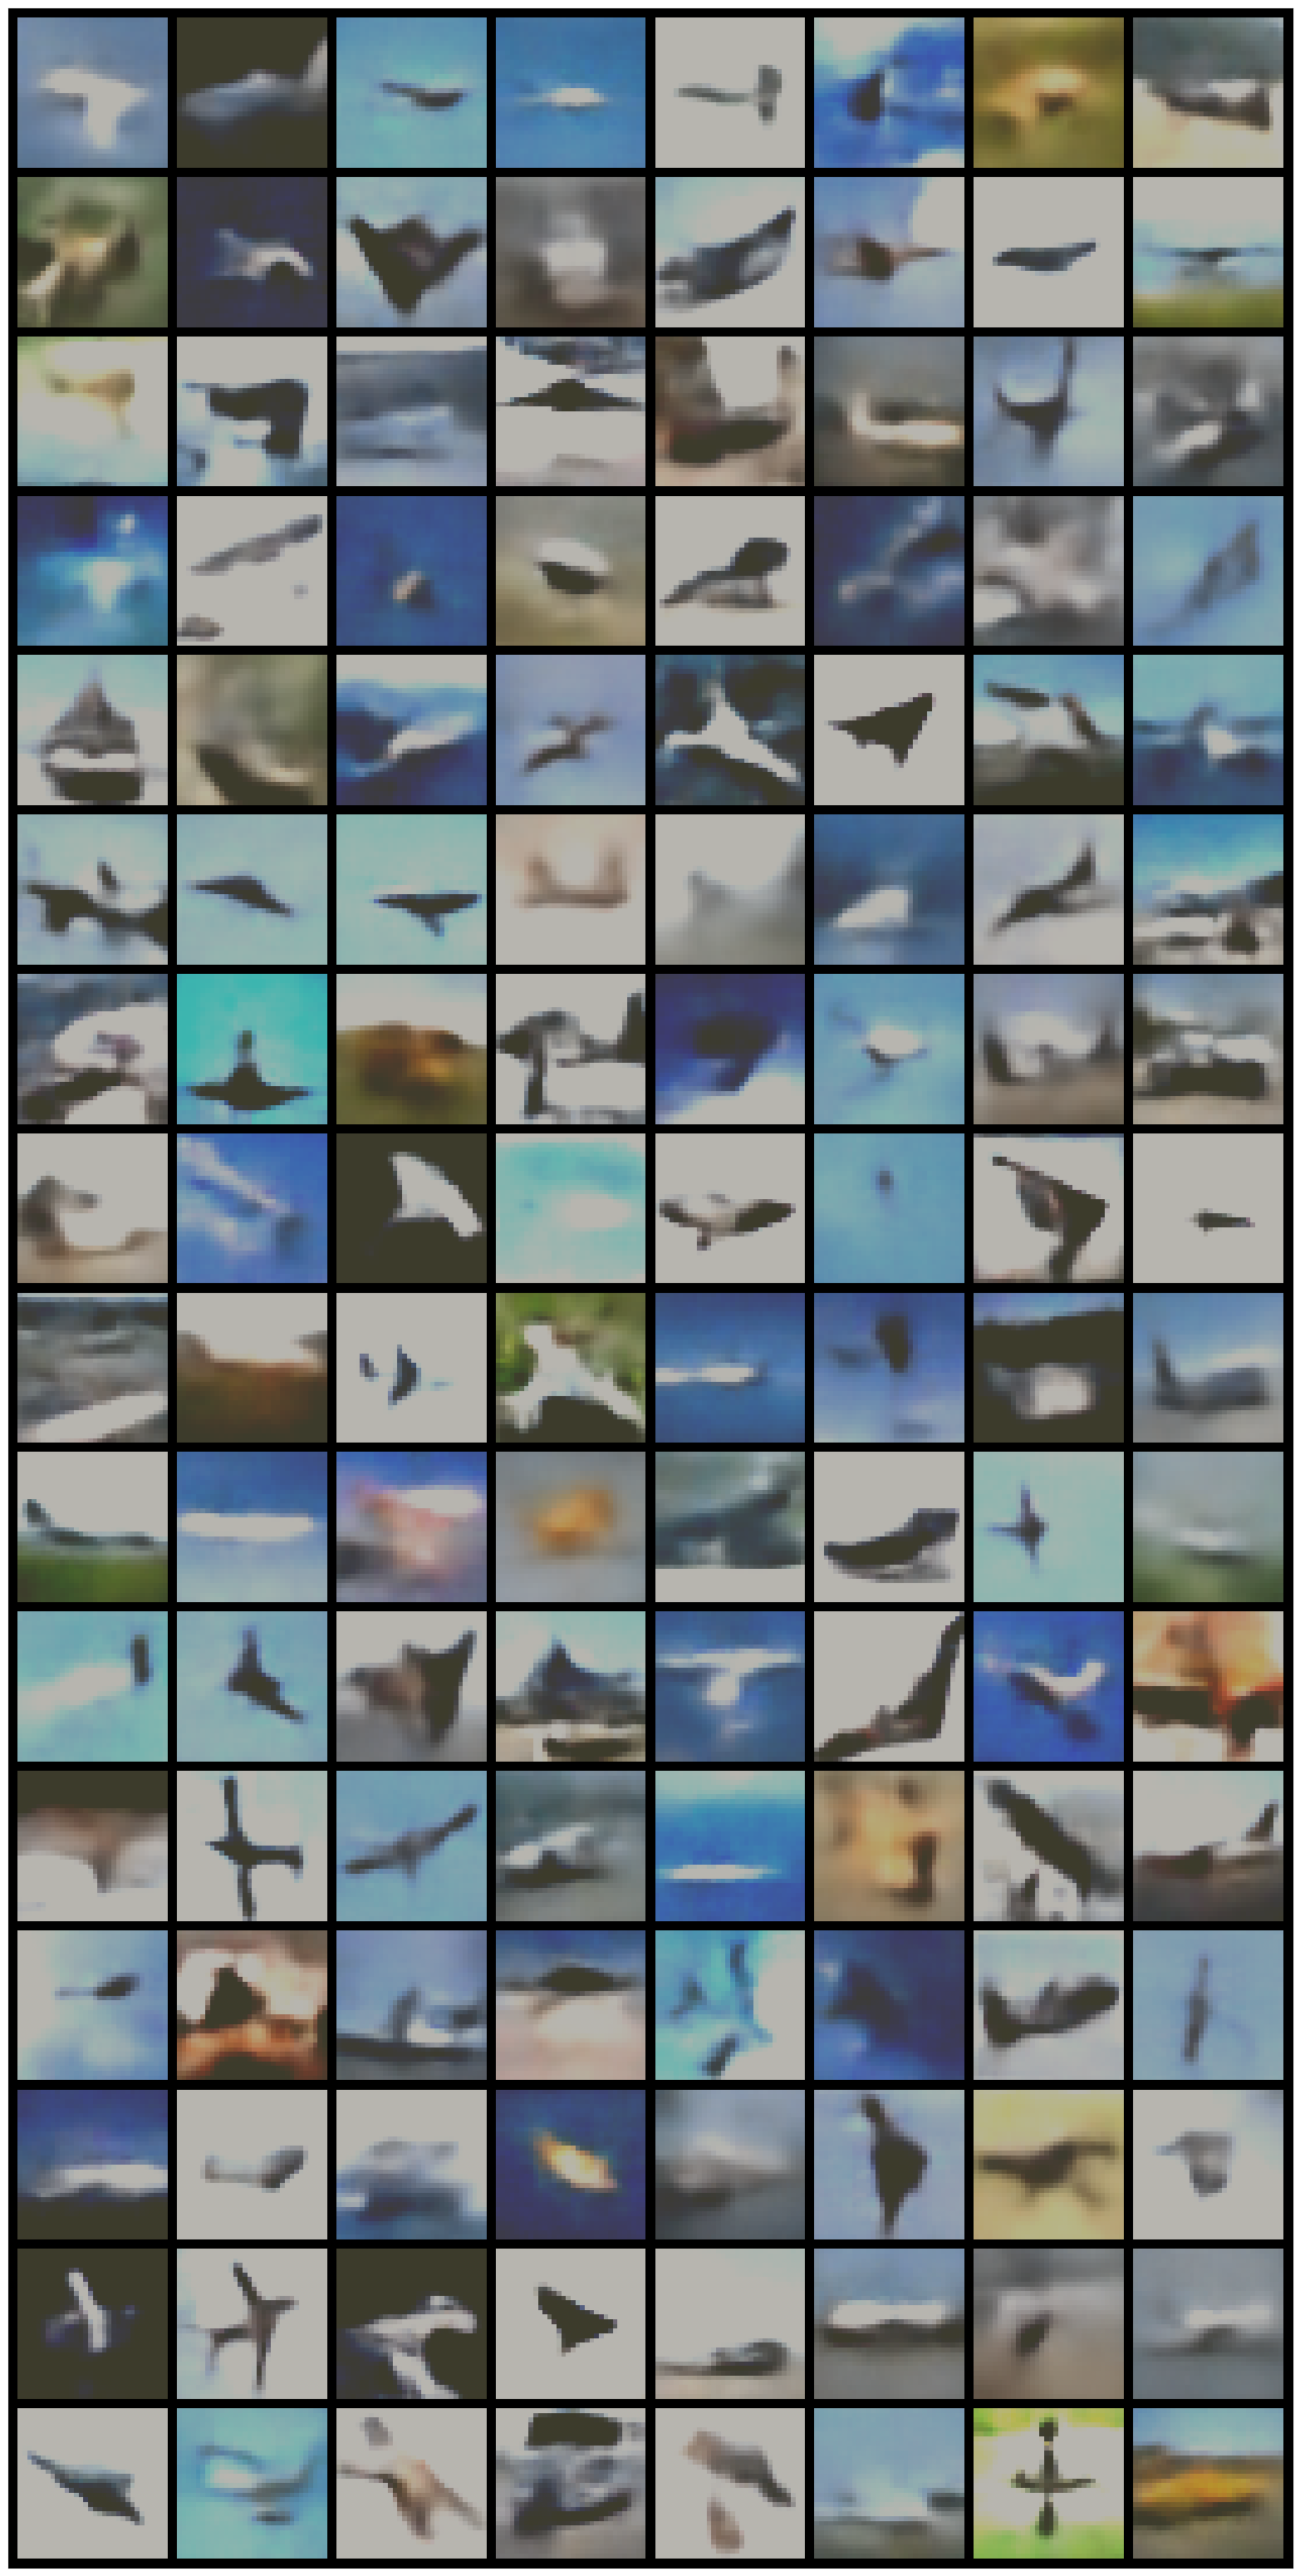

In [10]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

# mean = [0.47889522, 0.47227842, 0.43047404]
# std = [0.24205776, 0.23828046, 0.25874835]

invnorm = transforms.Compose(
    [
        transforms.Normalize(mean = [0., 0., 0.], std = [1/0.24205776, 1/0.23828046, 1/0.25874835]),
        transforms.Normalize(mean = [-0.47889522, -0.47227842, -0.43047404], std = [1., 1., 1.]),
    ]
)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

    inv_recons = invnorm(recons)

grid = make_grid(inv_recons)
show(grid)

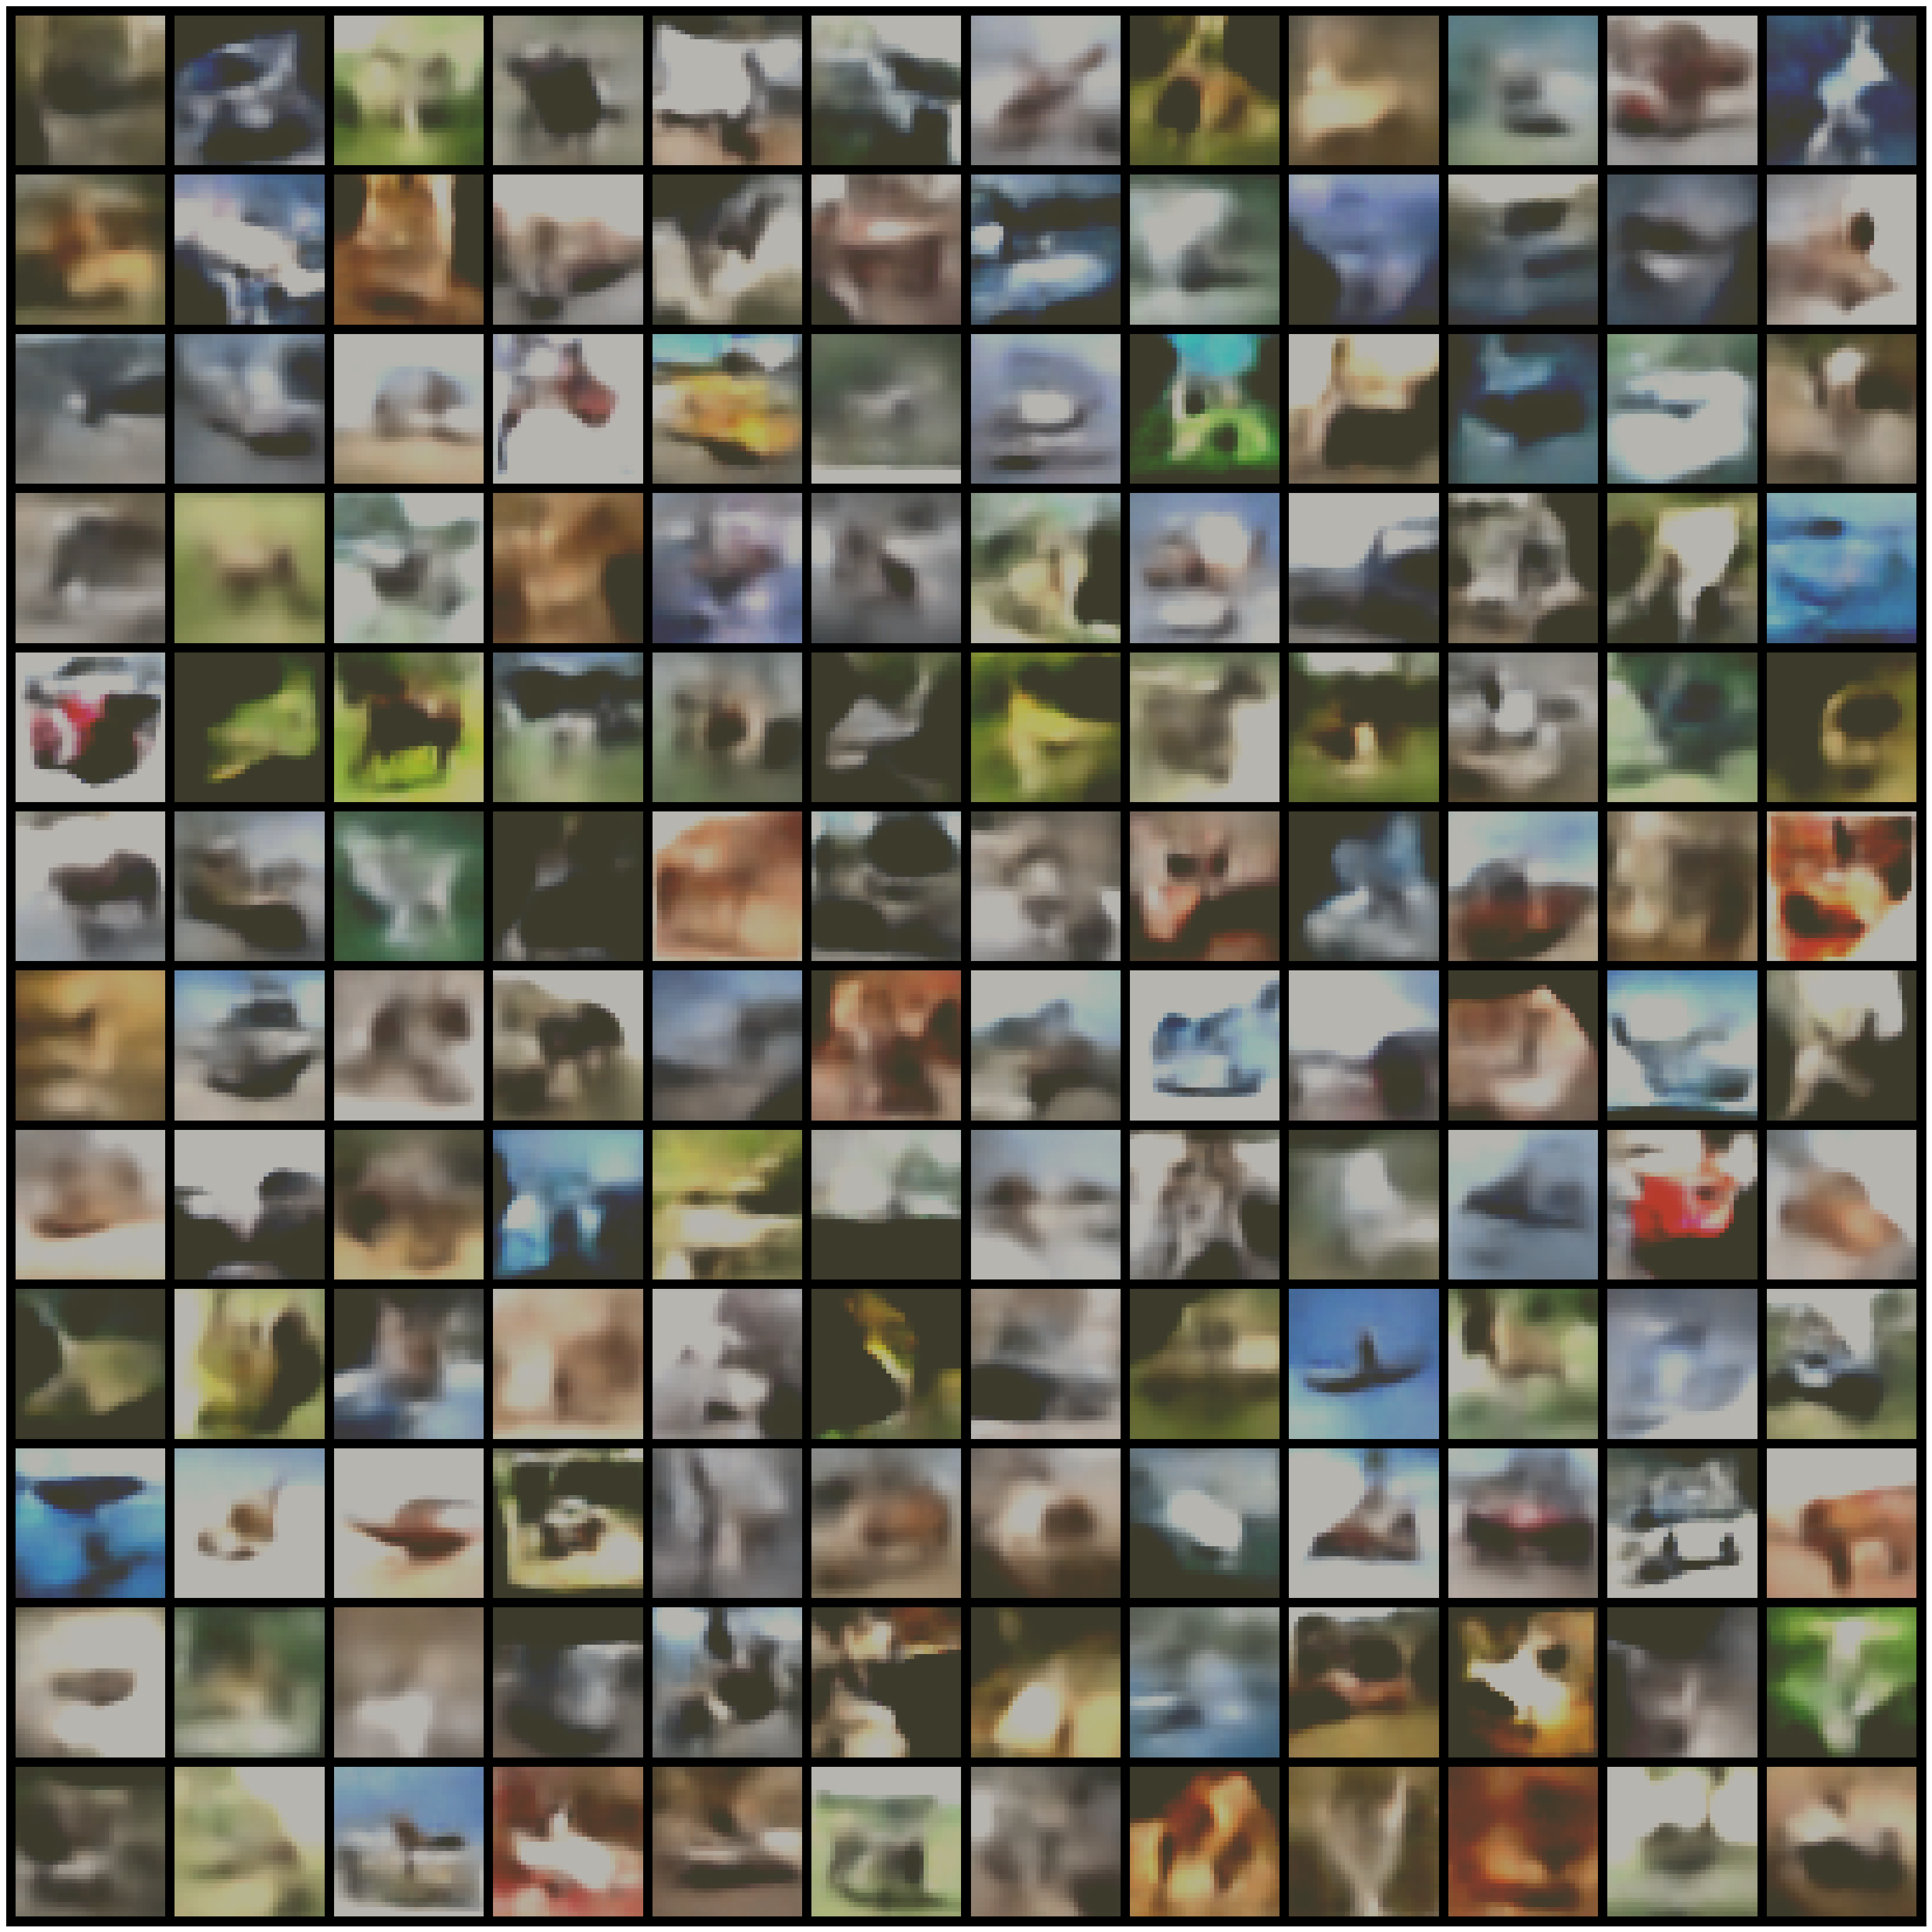

In [11]:
z = torch.randn(144, 512).to(device)

samples = model.decoder(z)

grid = make_grid(invnorm(samples), nrow=12)
show(grid)